In [177]:
import numpy as np
import ot
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from sklearn.metrics import pairwise_distances

In [1312]:
N_SOURCE = 20
N_TARGET = 10

a, b = 5*np.random.random(size=N_SOURCE) , 5*np.random.random(size=N_TARGET) 
a /= a.sum()
b /= b.sum()
c = pairwise_distances(np.arange(N_SOURCE).reshape(-1, 1), np.arange(N_TARGET).reshape(-1, 1))
c = c/(10*c.max())

In [1313]:
eps = 1e-3

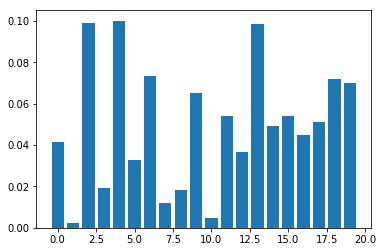

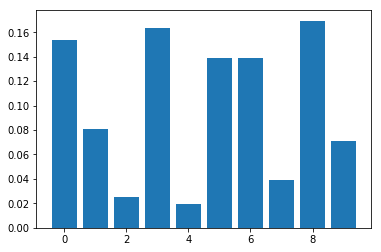

In [1314]:
plt.figure()
plt.bar(np.arange(N_SOURCE), a)
plt.show()
plt.figure()
plt.bar(np.arange(N_TARGET), b)
plt.show()

In [1315]:
def semi_dual_sag(a, b, c, eps, n_iter):
    L = np.max(a/eps)
    
    n_source = a.shape[0]
    n_target = b.shape[0]
    
    step = 2/(L*n_source)

    vs = []
    
    v = np.zeros(n_target)
    d = np.zeros(n_target)
    g = np.zeros((n_source, n_target))
    
    for _ in range(n_iter):
        i = random.randrange(n_source)
        d -= g[i, :]
        
        val = (1/eps)*(v - c[i, :])
        tmp = b * np.exp(val - np.max(val)) # Softmax trick
        grad = b - tmp/tmp.sum()

        g[i, :] = a[i]*grad

        d += g[i, :]
        v += step*d

        vs.append(v)

    u = -eps*np.log(np.sum(np.exp((v - c)/eps) * b, axis=1))
    pi = (np.exp((u[:, np.newaxis] + v[np.newaxis, :] - c)/eps)* 
                  a[:, np.newaxis] * b[np.newaxis, :])
    
    return pi

In [1316]:
pi = semi_dual_sag(a, b, c, eps, 50000)

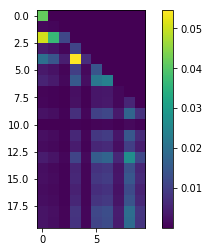

In [1317]:
plt.imshow(pi)
plt.colorbar()

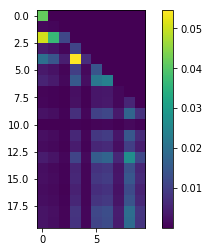

In [1327]:
plt.imshow(ot.sinkhorn(a, b, c, eps))
plt.colorbar()

In [1336]:
print(np.linalg.norm(ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag') - 
                     ot.sinkhorn(a, b, c, eps)))
print(np.linalg.norm(semi_dual_sag(a, b, c, eps, 100) - ot.sinkhorn(a, b, c, eps)))

6.230489862054925e-06
0.11720776843986794


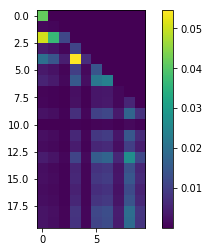

In [1329]:
plt.imshow(ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag'))
plt.colorbar()

In [1330]:
%%timeit
l = ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag', numItermax=1000)

32.7 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1331]:
%%timeit
l2 =semi_dual_sag(a, b, c, eps, 1000)

32 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
%%prun
l = ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag', numItermax=100000)

         704515 function calls in 7.027 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.633    2.633    6.989    6.989 stochastic.py:87(sag_entropic_transport)
   100000    2.474    0.000    3.739    0.000 stochastic.py:13(coordinate_grad_semi_dual)
   101000    0.656    0.000    0.656    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100000    0.613    0.000    0.613    0.000 {method 'randint' of 'mtrand.RandomState' objects}
   101000    0.303    0.000    1.012    0.000 fromnumeric.py:64(_wrapreduction)
   100500    0.211    0.000    1.268    0.000 fromnumeric.py:1821(sum)
   101000    0.052    0.000    0.052    0.000 {method 'items' of 'dict' objects}
   100500    0.048    0.000    0.048    0.000 {built-in method builtins.isinstance}
        1    0.022    0.022    7.026    7.026 stochastic.py:331(solve_semi_dual_entropic)
        1    0.009    0.009    0.015    0.015 stochastic.py:258(c_transform_entr

In [81]:
%%prun
l2 =semi_dual_sag(a, b, c, eps, 100000)

         802441 function calls in 7.147 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.529    5.529    7.147    7.147 <ipython-input-80-e207436f3c31>:1(semi_dual_sag)
   100002    0.808    0.000    0.808    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100000    0.192    0.000    0.269    0.000 random.py:224(_randbelow)
   100000    0.180    0.000    1.122    0.000 {method 'sum' of 'numpy.ndarray' objects}
   100000    0.166    0.000    0.435    0.000 random.py:174(randrange)
   100000    0.133    0.000    0.942    0.000 _methods.py:34(_sum)
   100000    0.059    0.000    0.059    0.000 {method 'append' of 'list' objects}
   102425    0.057    0.000    0.057    0.000 {method 'getrandbits' of '_random.Random' objects}
   100000    0.020    0.000    0.020    0.000 {method 'bit_length' of 'int' objects}
        3    0.002    0.001    0.002    0.001 {built-in method numpy.core.multiarray.zeros}
        1  

In [70]:
import random

In [72]:
%timeit np.random.randint(1000)

4.12 µs ± 723 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [74]:
%timeit random.randint(0, 1000 - 1)

3.51 µs ± 807 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [75]:
%timeit random.randrange(1000)

2.31 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Semi-discrete optimal transport

### 1D

In [1294]:

mu_m = [0.3, 1.2]
mu_std = [0.3, 0.1]
def mu(n):
    p = np.random.random(size=n)>0.4
    return (np.random.normal(loc=mu_m[0], scale=mu_std[0], size=n)*p + 
            np.random.normal(loc=mu_m[1], scale=mu_std[1], size=n)*(1-p))

sample = mu(1000000)
nu_support = np.arange(sample.min(), sample.max(), 0.01)
nu = np.zeros_like(nu_support)
for i in np.random.randint((2/20)*len(nu_support), (18/20)*len(nu_support), size=5):
    nu[i] += np.random.random()
    
nu = nu/nu.sum()

<BarContainer object of 276 artists>

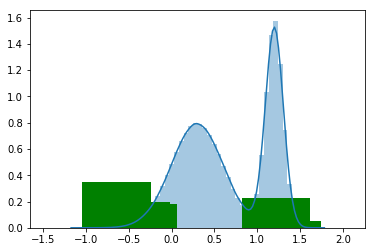

In [1295]:
fig, ax = plt.subplots()
sns.distplot(sample, ax=ax)#, bins=100, density=True)
ax.bar(nu_support, nu, color='g')

In [1296]:
len(nu_support)

276

In [1297]:
N_SOURCE

20

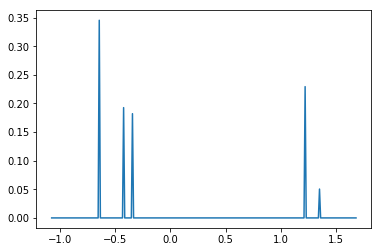

In [1298]:
plt.plot(nu_support, nu)

In [1299]:
v_tilde = np.zeros(nu.size)
v = v_tilde.copy()
eps=0.1
dist = lambda x, nu: np.abs(nu-x)/10
step = 0.01

for k in tqdm(range(1, 100000)):
    x = mu(1)[0]
    c = dist(x, nu_support)

    tmp = nu * np.exp((1/eps)*(v_tilde - c))
    grad = nu - tmp/tmp.sum()
    
    v_tilde = v_tilde + (step/np.sqrt(k))*grad
    v = (1/k)*v_tilde + (1-(1/k))*v





  0%|          | 0/99999 [00:00<?, ?it/s]


  1%|          | 849/99999 [00:00<00:11, 8486.35it/s]


  2%|▏         | 1694/99999 [00:00<00:11, 8473.47it/s]


  3%|▎         | 2609/99999 [00:00<00:11, 8665.66it/s]


  4%|▎         | 3556/99999 [00:00<00:10, 8892.02it/s]


  5%|▌         | 5175/99999 [00:00<00:09, 10282.01it/s]


  7%|▋         | 6512/99999 [00:00<00:08, 11046.72it/s]


  8%|▊         | 7739/99999 [00:00<00:08, 11386.41it/s]


  9%|▉         | 9102/99999 [00:00<00:07, 11976.65it/s]


 11%|█         | 10657/99999 [00:00<00:06, 12862.25it/s]


 12%|█▏        | 12494/99999 [00:01<00:06, 14132.74it/s]


 14%|█▍        | 13957/99999 [00:01<00:06, 12690.23it/s]


 15%|█▌        | 15407/99999 [00:01<00:06, 13182.58it/s]


 17%|█▋        | 16774/99999 [00:01<00:06, 12668.93it/s]


 18%|█▊        | 18441/99999 [00:01<00:05, 13651.31it/s]


 20%|█▉        | 19855/99999 [00:01<00:06, 13055.66it/s]


 21%|██        | 21201/99999 [00:01<00:06, 11787.33it/s]


 22%|██▏       | 22431

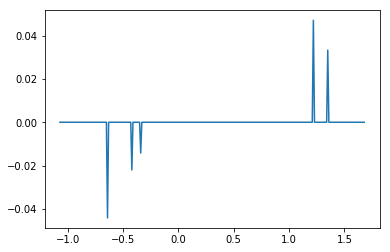

In [1300]:
plt.plot(nu_support, -v)

In [1301]:
v[np.abs(v)>0]

array([ 0.04411236,  0.02198304,  0.01420253, -0.04703963, -0.0332583 ])

In [1302]:
s = v[np.abs(v)>0]*nu_support[np.abs(v)>0] 
p = np.zeros(len(s)-1)
for i in range(len(s)-1):
    p[i] = (s[i+1] + s[i])/2

In [1303]:
all_dists = dist(np.linspace(nu_support.min(), nu_support.max(), 2000).reshape(-1, 1), 
                 nu_support[np.abs(v)>0].reshape(1, -1))
f = np.exp((v[np.abs(v)>0] - all_dists)/eps)
f /= f.sum(axis=1).reshape(-1, 1)

In [1304]:
all_dists = dist(np.linspace(nu_support.min(), nu_support.max(), 500).reshape(-1, 1), 
                 nu_support[np.abs(v)>0].reshape(1, -1))
expo = np.exp((v[np.abs(v)>0] - all_dists)/eps)
g_ctrans = - eps* np.log(np.sum(expo*nu[np.abs(v)>0], axis=1))

In [1305]:
mil = []
for i in range(len(v[np.abs(v)>0])):
    zer = np.nonzero(f.argmax(axis=1)==i)[0]
    if len(zer):
        mil.append(np.linspace(nu_support.min(), nu_support.max(), 2000)[int(np.mean(zer))])
    else:
        t = i+1
        while not len(np.nonzero(f.argmax(axis=1)==t)[0]):
            t += 1
        mil.append(np.linspace(nu_support.min(), 
                               nu_support.max(), 
                               2000)[np.min(np.nonzero(f.argmax(axis=1)==t)[0])])

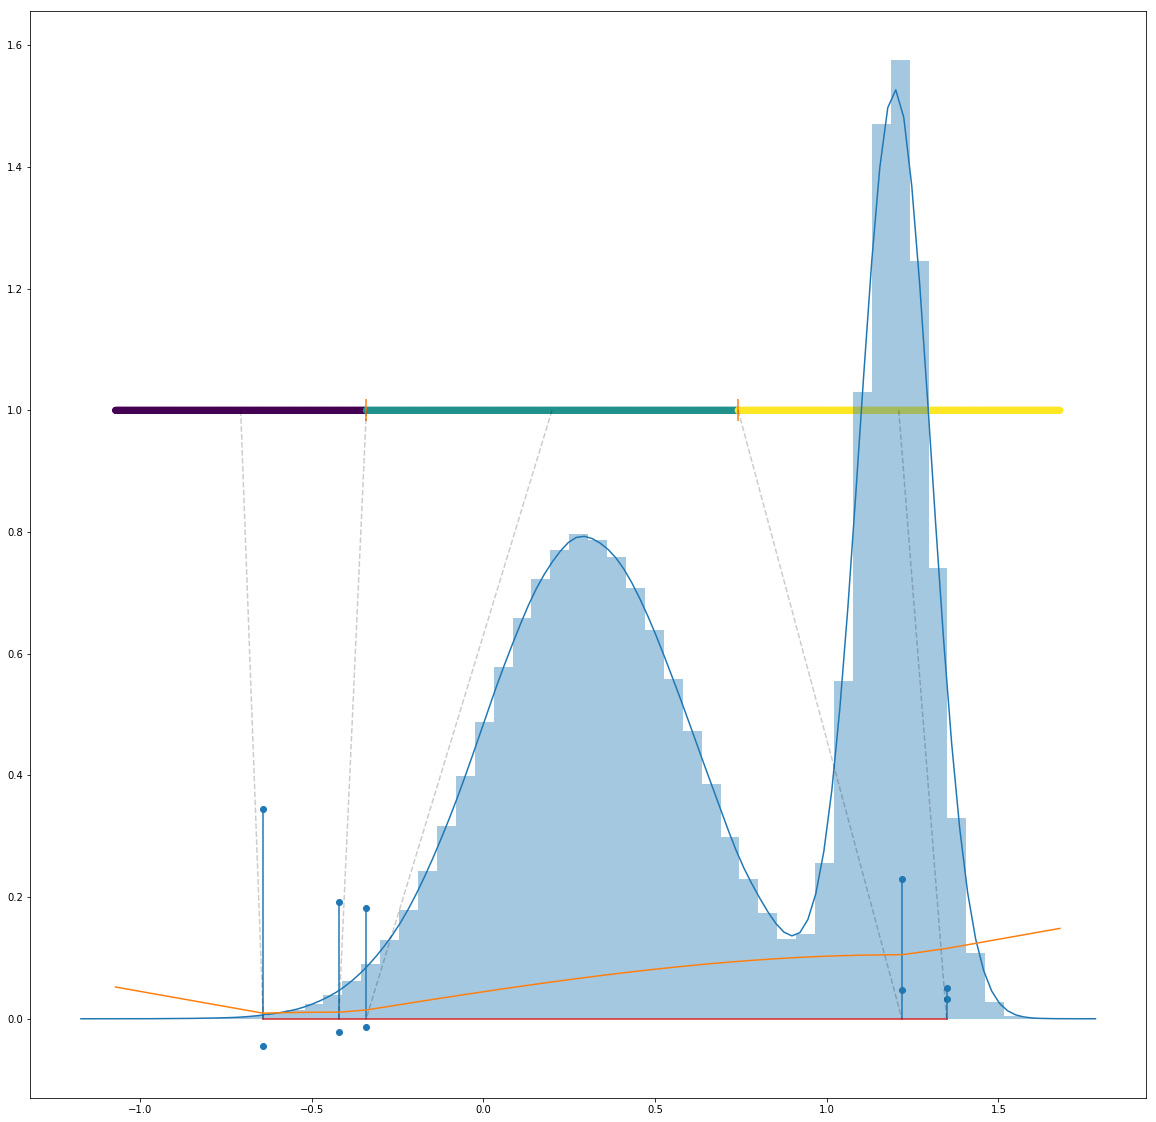

In [1307]:
plt.figure(figsize=(20, 20))
sns.distplot(sample)
plt.stem(nu_support[nu!=0], nu[nu!=0])

plt.scatter(nu_support[np.abs(v)>0],  - v[np.abs(v)>0])
plt.plot(np.linspace(nu_support.min(), nu_support.max(), 500), g_ctrans)
plt.scatter(np.linspace(nu_support.min(), nu_support.max(), 2000), 
            np.zeros(2000)+1, 
            c=f.argmax(axis=1), 
            marker='o')

for n, m in enumerate(mil):
    plt.plot([m, nu_support[np.abs(v)>0][n]], [1, 0], 'k--', alpha=0.2)
    
plt.scatter(np.linspace(nu_support.min(), nu_support.max(), 2000)[np.nonzero(np.diff(f.argmax(axis=1)))[0]], 
            np.ones(len(np.nonzero(np.diff(f.argmax(axis=1)))[0])), 
            marker='|',
            s=500)

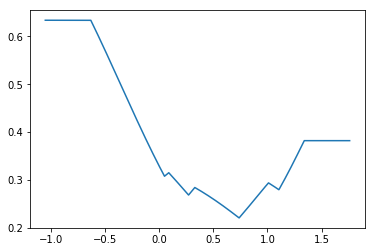

In [750]:
plt.plot(np.linspace(nu_support.min(), nu_support.max(), 2000),f.max(axis=1))


In [909]:
class MultiNormal:
    def __init__(self):
        self.s = np.diag([np.random.randint(1, 10) for i in range(2)])  - np.random.random((2, 2))
        self.s = (self.s + self.s.T)/2
        self.mu = 20*np.random.random(2) + 1

    def __call__(self, size=1):
        return np.random.multivariate_normal(self.mu, self.s, size=size)

In [972]:
def n_gauss(p):
    normals = [MultiNormal() for _ in range(p)]
    pi = np.random.random(size=p)
    pi/=pi.sum()
    
    def mu(n): 
        ran = np.random.random(n)
        
        pred = np.array([m(n) for m in normals])
        print(pred.shape)
        print(pred[ran.reshape(-1, 1) < pi.reshape(1, -1), :].shape)
        return (m1(n)*p.reshape(-1, 1) + m2(n)*(1-p).reshape(-1, 1))
    
    return mu

In [973]:
mmu = n_gauss(3)
mmu(1000).shape

(3, 1000, 2)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 1000

In [1037]:
nu_supp = np.random.uniform(d.min(), d.max(), size=(10, 2))
nu = np.random.random(size=len(nu_supp))
nu/=nu.sum()

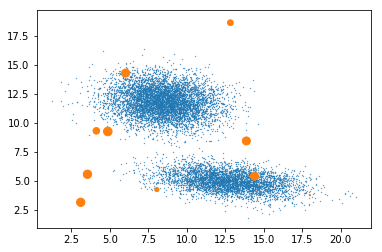

In [1038]:
fig, ax = plt.subplots()
d = mu(10000)
ax.scatter(d[:, 0], d[:, 1], s=0.1)
ax.scatter(nu_supp[:, 0], nu_supp[:, 1], s=500*nu)
#ax.scatter(v[:, 0], v[:, 1])

In [1128]:
v_tilde = np.zeros(nu.shape)
v = v_tilde.copy()
eps=0.05
dist = lambda x, nu: np.sqrt(np.sum((nu-x)**2, axis=1))/10
step = 0.01

for k in tqdm(range(1, 1000000)):
    x = mu(1)[0]
    c = dist(x, nu_supp)

    tmp = nu * np.exp((1/eps)*(v_tilde - c))
    grad = nu - tmp/tmp.sum()
    
    v_tilde = v_tilde + (step/np.sqrt(k))*grad
    v = (1/k)*v_tilde + (1-(1/k))*v




  0%|          | 0/999999 [00:00<?, ?it/s]


  0%|          | 148/999999 [00:00<11:16, 1478.95it/s]


  0%|          | 268/999999 [00:00<12:04, 1380.40it/s]


  0%|          | 477/999999 [00:00<10:50, 1536.31it/s]


  0%|          | 714/999999 [00:00<09:42, 1716.61it/s]


  0%|          | 946/999999 [00:00<08:56, 1861.74it/s]


  0%|          | 1150/999999 [00:00<08:42, 1910.38it/s]


  0%|          | 1349/999999 [00:00<08:36, 1932.38it/s]


  0%|          | 1585/999999 [00:00<08:08, 2042.27it/s]


  0%|          | 1812/999999 [00:00<07:54, 2104.92it/s]


  0%|          | 2022/999999 [00:01<08:06, 2052.87it/s]


  0%|          | 2227/999999 [00:01<08:20, 1994.64it/s]


  0%|          | 2430/999999 [00:01<08:17, 2003.22it/s]


  0%|          | 2631/999999 [00:01<08:20, 1993.12it/s]


  0%|          | 2851/999999 [00:01<08:06, 2049.30it/s]


  0%|          | 3099/999999 [00:01<07:41, 2160.66it/s]


  0%|          | 3355/999999 [00:01<07:19, 2266.59it/s]


  0%|          | 3597/999999 

In [1129]:
x, y = np.meshgrid(np.linspace(d.min(), d.max(), 500), np.linspace(d.min(), d.max(), 500))

In [1130]:
all_dists = np.sqrt(np.sum((np.concatenate((x.reshape(-1, 1), 
                            y.reshape(-1, 1)), 
                            axis=1).reshape(-1,1, 2) -  nu_supp)**2, axis=2))

expo = np.exp((v - all_dists)/eps)
g_ctrans = - eps* np.log(np.sum(expo*nu, axis=1))

In [1131]:
f = np.exp((v - all_dists)/eps)
f /= f.sum(axis=1).reshape(-1, 1)

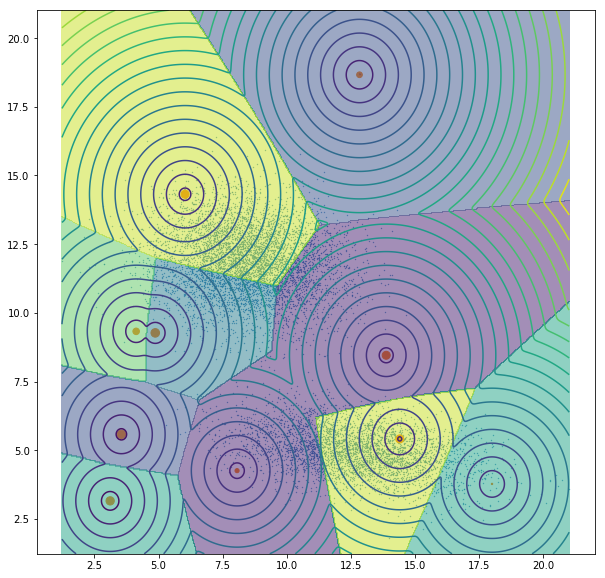

In [1133]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(d[:, 0], d[:, 1], s=0.1)
ax.scatter(nu_supp[:, 0], nu_supp[:, 1], s=500*nu)
ax.contour(x, y, g_ctrans.reshape(500, 500), 20)
ax.contourf(x, y, np.argmax(f, axis=1).reshape(500, 500), alpha=0.5)